In [1]:
import pylab as plt
import numpy as np
from scipy import interpolate
import cPickle
%matplotlib inline

Là juste je charge les données pour une visite que j'aime bien (id: 137108 en z) et où il y a tout les résultats dont j'ai besoin pour essayer de refaire le fit sur la fonction à 2-point.

In [2]:
dic = cPickle.load(open('../../astrometry/tests/137108_z/gp_output_137108.pkl'))

Figure pour montrer le champ de deplacement que j'analyse. Ici qu'un champs scalaire, je regarde qu'une composante du champ de residus astrometrique (du) 

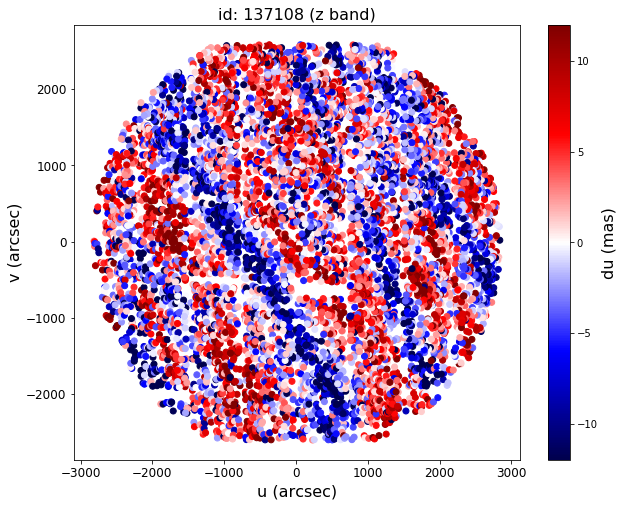

In [3]:
plt.figure(figsize=(10,8))
plt.scatter(dic['input_data']['u'], dic['input_data']['v'], 
            c=dic['input_data']['du'], cmap=plt.cm.seismic, vmin=-12, vmax=12)
cb = plt.colorbar()
cb.set_label('du (mas)', fontsize=16)
plt.xlabel('u (arcsec)', fontsize=16)
plt.ylabel('v (arcsec)', fontsize=16)
plt.title('id: 137108 (z band)', fontsize=16)
xt = plt.xticks(fontsize=12)
yt = plt.yticks(fontsize=12)

Ici quelques fontions pour faire de jolie graphique de ma fonction à 2 point et du resultat du fit. 

In [4]:
def return_var_map(weight, xi):
    N = int(np.sqrt(len(xi)))
    var = np.diag(np.linalg.inv(weight))
    VAR = np.zeros(N*N)
    I = 0
    for i in range(N*N):
        if xi[i] !=0:
            VAR[i] = var[I]
            I+=1
        if I == len(var):
            break
    VAR = VAR.reshape(N,N) + np.flipud(np.fliplr(VAR.reshape(N,N)))
    if N%2 == 1:
        VAR[N/2, N/2] /= 2.
    return VAR


class interp_dic(object):
    
    def __init__(self, dic, key='gpu'):

        self._2pcf_dist = dic['gp_output']['%s.2pcf_dist'%(key)]
        self._2pcf_weight = dic['gp_output']['%s.2pcf_weight'%(key)]
        self._2pcf_fit = dic['gp_output']['%s.2pcf_fit'%(key)]
        self._2pcf = dic['gp_output']['%s.2pcf'%(key)]
        self._2pcf_mask = dic['gp_output']['%s.2pcf_mask'%(key)]



def plot_correlation_function(interp, save=False, rep='',
                              specific_name_kernel='VK', NAME='du', exp='0', other_fit=None):
    
    if other_fit is None: 
        FIT = interp._2pcf_fit
    else:
        FIT = other_fit

    EXT = [np.min(interp._2pcf_dist[:,0]/60.), np.max(interp._2pcf_dist[:,0]/60.),
           np.min(interp._2pcf_dist[:,1]/60.), np.max(interp._2pcf_dist[:,1]/60.)]
    CM = plt.cm.seismic

    MAX = np.max(interp._2pcf)
    N = int(np.sqrt(len(interp._2pcf)))
    plt.figure(figsize=(14,5) ,frameon=False)
    plt.gca().patch.set_alpha(0)
    plt.subplots_adjust(wspace=0.5,left=0.07,right=0.95, bottom=0.15,top=0.85)
    plt.suptitle(NAME+' anisotropy 2-PCF (%s)'%(specific_name_kernel) , fontsize=16)
    plt.subplot(1,3,1)
    plt.imshow(interp._2pcf.reshape(N,N), extent=EXT, interpolation='nearest', origin='lower',
               vmin=-MAX, vmax=MAX, cmap=CM)
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    cbar.set_label('$\\xi$',fontsize=20)
    plt.xlabel('$\\theta_X$ (arcmin)',fontsize=20)
    plt.ylabel('$\\theta_Y$ (arcmin)',fontsize=20)
    plt.title('Measured 2-PCF',fontsize=16)
    
    plt.subplot(1,3,2)
    plt.imshow(FIT.reshape(N,N), extent=EXT, interpolation='nearest',
               origin='lower',vmin=-MAX,vmax=MAX, cmap=CM)
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    cbar.set_label('$\\xi\'$',fontsize=20)
    plt.xlabel('$\\theta_X$ (arcmin)',fontsize=20)
    plt.ylabel('$\\theta_Y$ (arcmin)',fontsize=20)

    var = return_var_map(interp._2pcf_weight, interp._2pcf)
    cm_residual = plt.matplotlib.cm.get_cmap('RdBu',10)
    Res = interp._2pcf[interp._2pcf_mask] - FIT[interp._2pcf_mask]
    chi2 = Res.dot(interp._2pcf_weight).dot(Res)
    dof = np.sum(interp._2pcf_mask) - 4.

    pull = (interp._2pcf.reshape(N,N) - FIT.reshape(N,N)) / np.sqrt(var)

    #plt.title('Fitted 2-PCF'%(chi2/dof),fontsize=16)

    plt.subplot(1,3,3)

    plt.imshow(pull, extent=EXT, interpolation='nearest', origin='lower', vmin=-5., vmax=+5., cmap=cm_residual)
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    cbar.set_label('$\\frac{\\xi-\\xi\'}{\sigma_{\\xi}}$',fontsize=20)
    plt.xlabel('$\\theta_X$ (arcmin)',fontsize=20)
    plt.ylabel('$\\theta_Y$ (arcmin)',fontsize=20)
    plt.title('Pull',fontsize=16)

Ici je plot le resultat du fit avec la fonction analytique de type Von Karman 

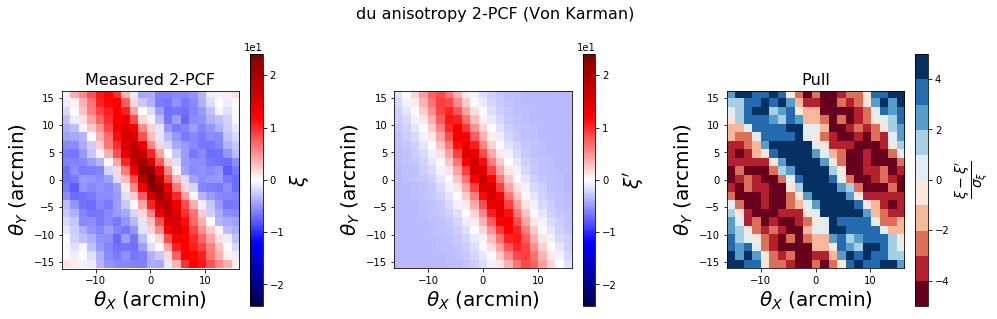

In [5]:
interp = interp_dic(dic, key='gpu')
plot_correlation_function(interp, specific_name_kernel='Von Karman')

La je fit le spline directement sur ma fonction à 2-point et je plot le resultat qui est ci-dessous 

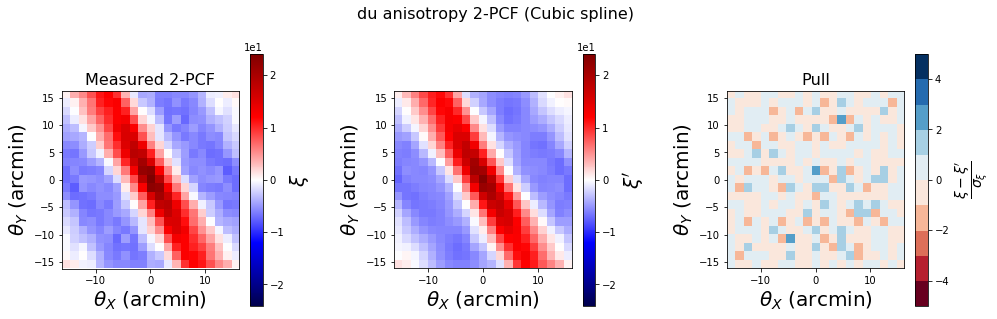

In [6]:
# spline 

var = return_var_map(interp._2pcf_weight, interp._2pcf)
var = var.reshape(np.shape(interp._2pcf))
N = int(np.sqrt(len(interp._2pcf_dist[:,0])))

tck = interpolate.bisplrep(interp._2pcf_dist[:,0], interp._2pcf_dist[:,1], interp._2pcf, w=1./var)

xnew = interp._2pcf_dist[:,0]
ynew = interp._2pcf_dist[:,1]

def return_spline(x, y, tck):
    return interpolate.bisplev(x, y, tck)

znew = np.array([return_spline(x, y, tck) for x,y in zip(xnew, ynew)])


plot_correlation_function(interp, other_fit=znew, specific_name_kernel='Cubic spline')

In [ ]:
# spline 

var = return_var_map(interp._2pcf_weight, interp._2pcf)
var = var.reshape(np.shape(interp._2pcf))
N = int(np.sqrt(len(interp._2pcf_dist[:,0])))

f = interpolate.interp2d(interp._2pcf_dist[:,0], interp._2pcf_dist[:,1], interp._2pcf)

xnew = interp._2pcf_dist[:,0]
ynew = interp._2pcf_dist[:,1]

def return_spline(x, y, tck):
    return interpolate.bisplev(x, y, tck)

znew = np.array([return_spline(x, y, tck) for x,y in zip(xnew, ynew)])


plot_correlation_function(interp, other_fit=znew, specific_name_kernel='Cubic spline')

Voila l'etape qui est longue, maintenant que je connais le resultat de mes splines et je veux evaluer la valeur de ma fonction a deux points pour toute mes pairs afin de consruire ma matrice de covariane (N*N ou N est le nombre d'objet que j'utilise sur le plan focal)

In [ ]:
def make_spline_kernel(u, v):

    ind = np.linspace(0, len(u)-1, len(u)).astype(int)
    i1, i2 = np.meshgrid(ind, ind)
    Filtre = (i1 >= i2) # je selectionne que la moitie des pairs (symetrie)                                                                                                                          
    i1 = i1.reshape(len(u)**2)
    i2 = i2.reshape(len(u)**2)
    Filtre = Filtre.reshape(len(u)**2)

    i1 = i1[Filtre]
    i2 = i2[Filtre]
    del Filtre

    # Make separation vectors and count pairs                                                                                                                   
    yshift = v[i2]-v[i1]
    xshift = u[i2]-u[i1]
    znew = [return_spline(x, y, tck) for x,y in zip(xshift, yshift)] #c est cette etape qui est longue a cause de la boucle et je ne vois pas comment faire autrement...
    
make_spline_kernel(dic['input_data']['u'], dic['input_data']['v'])